# GloVe Testbook
### Step 1 - load data & helper functions


In [1]:
import torch
import torch.nn as nn
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix

from collections import Counter
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

/home/cas/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# path to dataset
DATAPATH = 'data/upsampled_large.csv'
# device
device = 'cuda' # cpu

In [3]:
# takes in string & returns a cleaned string of all non-stop-words
def preprocess(text, lemmatizer = WordNetLemmatizer()):
    sw = set(stopwords.words('english'))
    text = re.sub(r'[^\w\s]', '', text).lower()
    s = ""
    for word in text.split():
        if word not in sw:
                s += (lemmatizer.lemmatize(word) + " ")
    return s


In [4]:
tokenizer = get_tokenizer("basic_english")
max_words = 20
embed_len=300
global_vectors = GloVe(name='840B', dim=embed_len)

In [5]:
# takes string, return 6000 dim GloVe vector
def to_vector(s):
    X = tokenizer(s)
    # fill / cut tokens to max size
    if len(X) < max_words:
        X = X+[""]*(max_words-len(X))
    else:
        X = X[:max_words]

    X_tensor = torch.zeros(1, max_words, embed_len)
    for i, j in enumerate(X):
        X_tensor[0][i] = global_vectors.get_vecs_by_tokens(j)
    return(X_tensor.reshape(1, -1))

In [6]:
x = to_vector("test")
y = to_vector("vetor")
Z = torch.cat((x, y), 1)
Z.shape

torch.Size([1, 12000])

### Step 2 - define pytorch custom dataset class

In [6]:
# config

# custom dataset class
class StanceDataset(Dataset):
    def __init__(self, stance_df,  val_split=False):
        """  Initalizes vectorizers, defines train/test splits
        Args:
            stance_df (pandas.DataFrame): the dataset
        """
        self.df = stance_df
        
        # splits (train, test, validation) 80/20 
        self.train, self.test = train_test_split(self.df, test_size=0.2, shuffle=True)
        if val_split == True:   
            # 50/50 val/test
            self.test, self.val = train_test_split(self.test, test_size=0.5, shuffle=False)
            self.val_len = len(self.val)
        # split sizes
        self.train_len = len(self.train)
        self.test_len = len(self.test)
        
        self._lookup_dict = {'train': (self.train, self.train_len),
                             'test': (self.test, self.test_len)}
        if val_split == True:
            self._lookup_dict.update({'val': (self.val, self.val_len)})

        self.set_split('train')


    def set_split(self, split='train'):
        """ selects the splits in the dataset using a column in the dataframe 
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """
        Args:
            index (int): index to current data point
        Returns:
            dictionary holding tensor data point feature (x_data) and skalar tensor label (y_data)
        """
        
        # get text values from current row
        row = (self._target_df.iloc[index])
        claim = [row['head']]
        body = [row['body']]

        # create 6k vector for each
        claim = to_vector(preprocess(claim[0]))
        body = to_vector(preprocess(body[0]))
        
        # 12k combined input vector
        x_data = torch.cat((claim, body), 1)

        # get stance & convert to tensor
        y_data = row['Stance']
        stance_map = {
            "agree": 0,
            "disagree": 1,
            "discuss": 2,
            "unrelated": 3
        }
        y_data = torch.tensor(stance_map[y_data])
        return {'x_data': x_data,
                'y_target': y_data}

In [8]:
def load_dataset(excel=True):
    """
    applies dataset class to dataset located at DATAPATH
    args:
        excel (bool): default true for .xlsx, else set false
    """
    print('loading dataset...')
    if excel == True:
        df = pd.read_excel(
            DATAPATH, 
            index_col=None, 
            header=0   
        )
    else:
        df = pd.read_csv(
            DATAPATH, 
            index_col=None,
            header=0   
        )
    print('loaded!')
    
    dataset = StanceDataset(df, val_split=False)
    return dataset

data = load_dataset(excel=False)

loading dataset...
loaded!


In [10]:
"""
Test block for getitem. This is what the training loop will call
"""

data.set_split('train')
print("should be the lenght of train split: ", len(data._target_df))

d = data.__getitem__(1)
print(d['x_data'])
print(d['y_target'])
print(len((d['x_data'])[0]))

should be the lenght of train split:  25360
tensor([[-0.4283, -0.3394,  0.0508,  ..., -0.0650, -0.2012, -0.6284]])
tensor(3)
12000


### Weighted Sampler

{'unrelated': 14602, 'discuss': 7120, 'agree': 2937, 'disagree': 701}


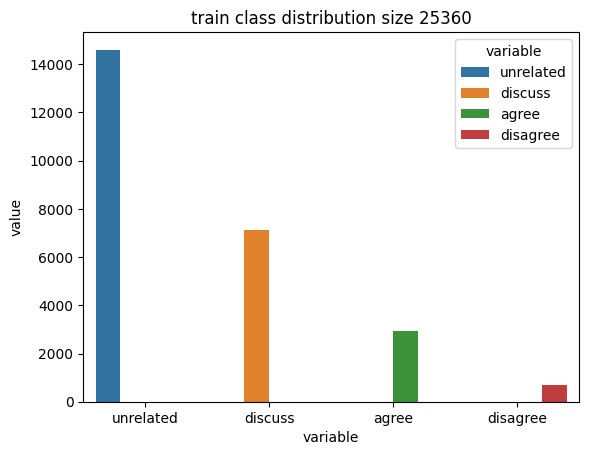

In [11]:
# distribution of labels (class distribution)
def dist_of(df):
    class_distribution = (pd.value_counts(df['Stance'])).to_dict()
    print(class_distribution)
    sns.barplot(data = pd.DataFrame.from_dict([class_distribution]).melt(), x = "variable", y="value", hue="variable").set_title(f'train class distribution size {len(df)}')

dist_of(data._target_df)

In [32]:
def sample(d):
    class_count = dict(pd.value_counts(d['Stance']))
    print(class_count)
    stance_map = {
        "agree": 0,
        "disagree": 1,
        "discuss": 2,
        "unrelated": 3
    }
    # fit the class count to sequence agree, disagree, discuss, unrelated
    cc = [0, 0, 0, 0]
    for key in class_count:
        cc[stance_map[key]] = class_count[key]

    weight = 1./torch.tensor(cc, dtype=torch.float).to(device)
    print(weight)
    
    # create array with weight for each data point
    target_list = [stance_map[(d.iloc[i]['Stance'])] for i in range(len(d))]
    samples_weight = torch.tensor([weight[t] for t in target_list]).to(device)

    weighted_sampler = WeightedRandomSampler(
        weights=samples_weight,
        num_samples=len(samples_weight),
        replacement=True
    )
    return weighted_sampler, weight

data.set_split('train')
train_sampler, train_weights = sample(data._target_df)

{'unrelated': 14595, 'discuss': 7115, 'agree': 2969, 'disagree': 681}
tensor([3.3681e-04, 1.4684e-03, 1.4055e-04, 6.8517e-05], device='cuda:0')


### Step 3 - Define model & training

In [22]:
# hyperparameters
in_dim = 12000
hidden_dim = 1200
hidden_dim2 = 120
out_dim = 4
epochs = 40
bs = 64 # batch size
lr = 0.001

In [23]:
# re-usable way to create dataloader
def make_batches(dataset, batch_size, shuffle=True, drop_last=True, sampler=None):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last, sampler=sampler)
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [34]:
# define neural net
class NN(nn.Module):
    def __init__(self, in_dim, hidden_dim, hidden_dim2, out_dim):
        super(NN, self).__init__()

        # define layers
        self.l1 = nn.Linear(in_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim2)
        self.relu = nn.ReLU()
        self.l3 = nn.Linear(hidden_dim2, out_dim)
    
    # applies layers with sample x
    def forward(self, x):
        out = self.l1(x).squeeze()
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

model = NN(in_dim=in_dim, hidden_dim=hidden_dim, hidden_dim2=hidden_dim2, out_dim=out_dim).to(device)

criterion = nn.CrossEntropyLoss(weight=train_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [30]:
"""
TRAIN function
"""

# setup
train_loss = []

def train(epoch):
  print('\n')
  # create new loader after each epoch
  data.set_split('train')
  train_loader = make_batches(data, bs, shuffle=False, sampler=train_sampler)

  model.train()

  running_loss = 0.
  last_loss = 0.
  epoch_loss = []
 
  for i, sample in enumerate(train_loader):
    # zero gradients each batch
    optimizer.zero_grad()
    
    inputs = ((sample)['x_data']).float()
    labels = sample['y_target']

    # predict for batch
    outputs = model(inputs)

    # compute loss and gradients
    loss = criterion(outputs, labels)
    epoch_loss.append(loss.item())
    loss.backward()

    # adjust weights
    optimizer.step()

    # intra-epoch reporting
    running_loss += loss.item()
    if i % 100 == 0:
            last_loss = running_loss / bs # 1000 loss per batch
            print('Epoch {} batch {} loss: {}'.format(epoch + 1, i + 1, last_loss))
            running_loss = 0.
    
  train_loss.append(sum(epoch_loss)/len(epoch_loss))

In [31]:
""" 
TEST function
"""

# setup
eval_loss = []
y_pred = []
y_true = []

def test(epoch):
  # create new loader after each epoch
  data.set_split('test')
  test_loader = make_batches(data, bs, shuffle=True)

  epoch_loss = []
  model.eval()
 
  with torch.no_grad():
    for i, sample in enumerate(test_loader):
      inputs = ((sample)['x_data']).float()
      labels = sample['y_target']
      
      # predict
      outputs=model(inputs)

      # compute loss
      loss = criterion(outputs, labels)
      epoch_loss.append(loss.item())

      # get metrics for feature report on last epoch
      if epoch == epochs-1:
        _, predictions = torch.max(outputs, 1)
        y_pred.extend(predictions.data.cpu().numpy())
        y_true.extend(labels.data.cpu().numpy())
      
 
  eval_loss.append(sum(epoch_loss)/len(epoch_loss))

In [35]:
epochs = 40
for epoch in range(epochs): 
  train(epoch)
  test(epoch)



Epoch 1 batch 1 loss: 0.021115759387612343
Epoch 1 batch 101 loss: 0.7972470235545188
Epoch 1 batch 201 loss: 0.47929392277728766
Epoch 1 batch 301 loss: 0.3731152346590534


Epoch 2 batch 1 loss: 0.003809749148786068
Epoch 2 batch 101 loss: 0.26348857721313834
Epoch 2 batch 201 loss: 0.23999856901355088
Epoch 2 batch 301 loss: 0.1840630142542068


Epoch 3 batch 1 loss: 0.0012345751747488976
Epoch 3 batch 101 loss: 0.18348512228112668
Epoch 3 batch 201 loss: 0.18745711277006194
Epoch 3 batch 301 loss: 0.14573282800847664


Epoch 4 batch 1 loss: 0.0007439806940965354
Epoch 4 batch 101 loss: 0.1293908583902521
Epoch 4 batch 201 loss: 0.1273444005928468
Epoch 4 batch 301 loss: 0.13264141147374175


Epoch 5 batch 1 loss: 0.0012072789249941707
Epoch 5 batch 101 loss: 0.0788914584700251
Epoch 5 batch 201 loss: 0.06656831641885219
Epoch 5 batch 301 loss: 0.06855175082455389


Epoch 6 batch 1 loss: 0.0008861299138516188
Epoch 6 batch 101 loss: 0.08403263853688259
Epoch 6 batch 201 loss: 0.06

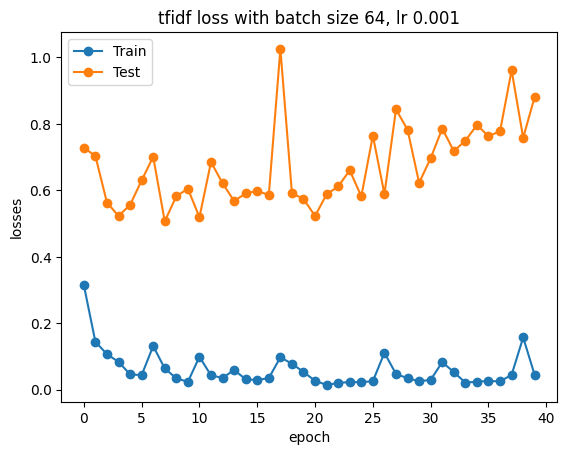

In [36]:
plt.plot(train_loss, '-o')
plt.plot(eval_loss,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test']) # 
plt.title(f'tfidf loss with batch size {bs}, lr {lr}')

plt.show()

In [37]:
# save losses to data frame
pd.DataFrame({'train': train_loss, 'eval': eval_loss}).to_csv("measures/glove_2hidden_loss_40.csv")

In [38]:
from sklearn.metrics import classification_report
 
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.91      0.84       709
           1       0.50      0.84      0.63       159
           2       0.95      0.88      0.92      1793
           3       0.95      0.92      0.93      3675

    accuracy                           0.91      6336
   macro avg       0.79      0.89      0.83      6336
weighted avg       0.92      0.91      0.91      6336



In [18]:
# save the model
# embedding_data_accuracy
torch.save(model.state_dict(), "models/glove_40.pth")

[[0.87277702 0.09036145 0.00852757 0.0111413 ]
 [0.02325581 0.77108434 0.00284252 0.00244565]
 [0.04787962 0.09638554 0.95110858 0.01902174]
 [0.05608755 0.04216867 0.03752132 0.9673913 ]]


<AxesSubplot: title={'center': 'cf matrix of testadata size 6340, lr: 0.001, batches: 64, epochs: 40'}>

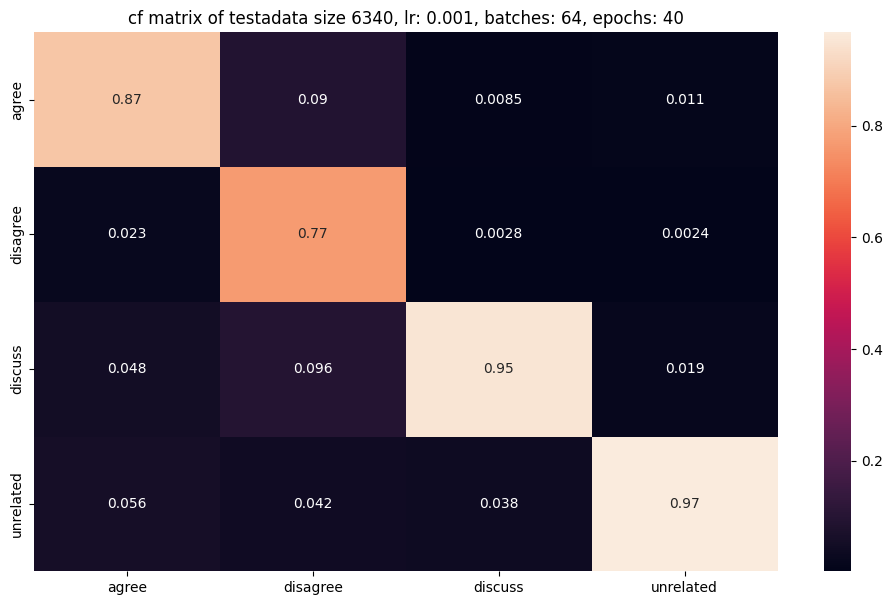

In [20]:
# confusion matrix
classes = ['agree', 'disagree', 'discuss', 'unrelated']

# Build confusion matrix (normalized as precision)
cf_matrix = confusion_matrix(y_true, y_pred, normalize='pred')
# precision, is in a sense correctness, and recall is completeness.

print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.title(f'cf matrix of testadata size {len(data._target_df)}, lr: {lr}, batches: {bs}, epochs: {epochs}')
sns.heatmap(df_cm, annot=True)

In [179]:
agree_row = (data.df).iloc[1]
disagree_row = (data.df).iloc[4434]

agree_head = agree_row['head']
agree_body = agree_row['body']

disagree_head = disagree_row['head']
disagree_body = disagree_row['body']

print(f"{agree_head} \n---\nshould agree with\n---\n{agree_body}")

Who Should Play Steve Jobs Now That Christian Bale Quit? 
---
should agree with
---
Christian Bale will not be starring as Steve Jobs in Aaron Sorkin's upcoming Steve Jobs biopic, according to The Hollywood Reporter. The actor has reportedly decided that he was "not right for the part," deciding to withdraw from the film.

Bale was announced as the star of the film just last week, with Sorkin saying that Christian Bale was "the best actor in a certain age range" to play Jobs, and that he had agreed to the part without an audition.

Set to be directed by Danny Boyle, who also directed the Oscar-winning hit Slumdog Millionaire, the upcoming Steve Jobs project focuses on three continuous 30-minute scenes that depict three of Apple's product launches.

While it is now unclear who will play Steve Jobs in the movie, Seth Rogen is reportedly in talks to play Apple co-founder Steve Wozniak, and Jessica Chastain, from The Help, is also being considered for an unspecified role in the film. Leona

In [183]:
print(f"{disagree_head} \n---\nshould disagree with\n---\n{disagree_body[:600]} ...")

NASA Confirms Earth Will Experience 6 Days of Total Darkness in December 2014! 
---
should disagree with
---
It may feel like winter is slowly squeezing all the sunlight out of your day, but if you see any news stories claiming Earth is headed for "Six Days of Total Darkness" then don't start stocking up on the tins of beans and torches just yet.

"Satirical news site" Huzlers.com has been spreading this fake story far and wide on the web this week, taking in numerous Facebook and Twitter users and encouraging them to post about what they're going to be up to during the six days of darkness.

The story on the vaguely official looking website titled "Nasa Confirms Earth Will Experience 6 Days of Total ...


In [184]:
claim = to_vector(preprocess(agree_head))
body = to_vector(preprocess(agree_body))
        
# 12k combined input vector
x_data = torch.cat((claim, body), 1)

# demo predict
pred = model(x_data)
pred_out, pred_idx = torch.max(pred, 0)

print(pred_out, pred_idx)
classes = ['agree', 'disagree', 'discuss', 'unrelated']
stance = classes[(pred_idx.data).numpy()]

print(stance)

tensor(10.2128, grad_fn=<MaxBackward0>) tensor(0)
agree
